In [3]:
# Importing necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [5]:
# Fetch stock data for a specific company (e.g., Apple - AAPL)
stock_symbol = 'AAPL'  # You can change the symbol
start_date = '2010-01-01'
end_date = '2024-01-01'

data = yf.download(stock_symbol, start=start_date, end=end_date)

# Display the first few rows of the data
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2010-01-04,6.447411,7.643214,7.660714,7.585000,7.622500,493729600
2010-01-05,6.458558,7.656429,7.699643,7.616071,7.664286,601904800
2010-01-06,6.355828,7.534643,7.686786,7.526786,7.656429,552160000
2010-01-07,6.344078,7.520714,7.571429,7.466071,7.562500,477131200
2010-01-08,6.386254,7.570714,7.571429,7.466429,7.510714,447610800


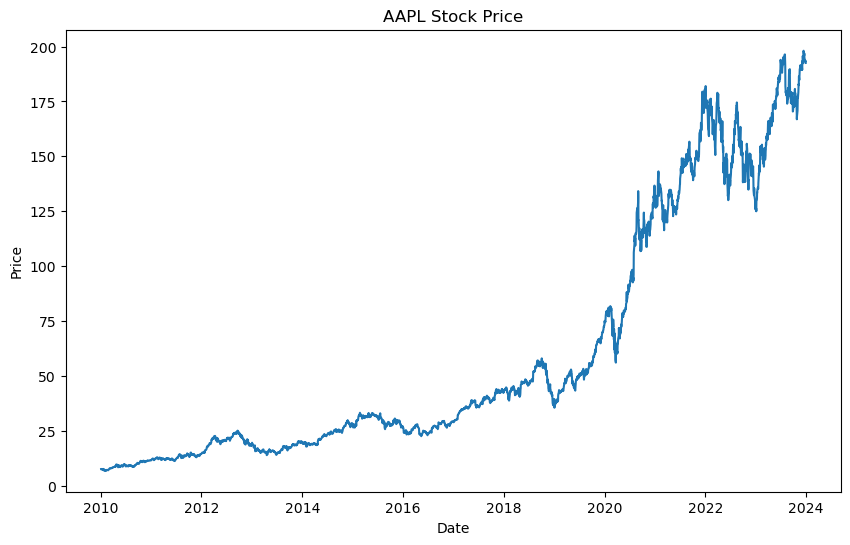

In [7]:
# Plot the Closing Price
plt.figure(figsize=(10,6))
plt.plot(data['Close'])
plt.title(f'{stock_symbol} Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


In [9]:
# Data Preprocessing: Scaling the closing prices
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [11]:
# Splitting data into training and testing sets
train_size = int(len(scaled_data) * 0.8)  # 80% for training and 20% for testing
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [13]:
# Creating the dataset with look-back period
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])  # The last 'time_step' closing prices
        y.append(data[i, 0])  # The next day's closing price
    return np.array(X), np.array(y)

In [15]:
# Reshape the input data into 3D array for LSTM [samples, time_step, features]
X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)
# Reshaping the data into 3D format required by LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [17]:
# Building the BiLSTM model
model = Sequential()

# Adding the Input layer and Bidirectional LSTM layers
model.add(Input(shape=(X_train.shape[1], 1)))  # Input layer
model.add(Bidirectional(LSTM(units=100, return_sequences=True)))  # First Bidirectional LSTM layer
model.add(Dropout(0.3))  # Dropout for regularization
model.add(Bidirectional(LSTM(units=100, return_sequences=False)))  # Second Bidirectional LSTM layer
model.add(Dropout(0.3))
model.add(Dense(units=1))  # Output layer

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [19]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - loss: 0.0052 - val_loss: 0.0023
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - loss: 4.5056e-04 - val_loss: 0.0013
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - loss: 5.9858e-04 - val_loss: 0.0051
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 3.7357e-04 - val_loss: 7.4103e-04
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 3.4561e-04 - val_loss: 7.0075e-04
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 3.6281e-04 - val_loss: 0.0018
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 3.2950e-04 - val_loss: 0.0010
Epoch 8/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - loss: 3.8947e-04 - val_loss: 7.9680e-04
Epoch 9/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - loss: 3.3509e-04 - val_loss: 0.0013
Epoch 10/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - loss: 3.2319e-04 - val_loss: 0.0019
Epoch 11/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - loss: 2.7924e-0

In [21]:
# Predicting the stock prices
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Undo the scaling

# Actual stock prices
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step


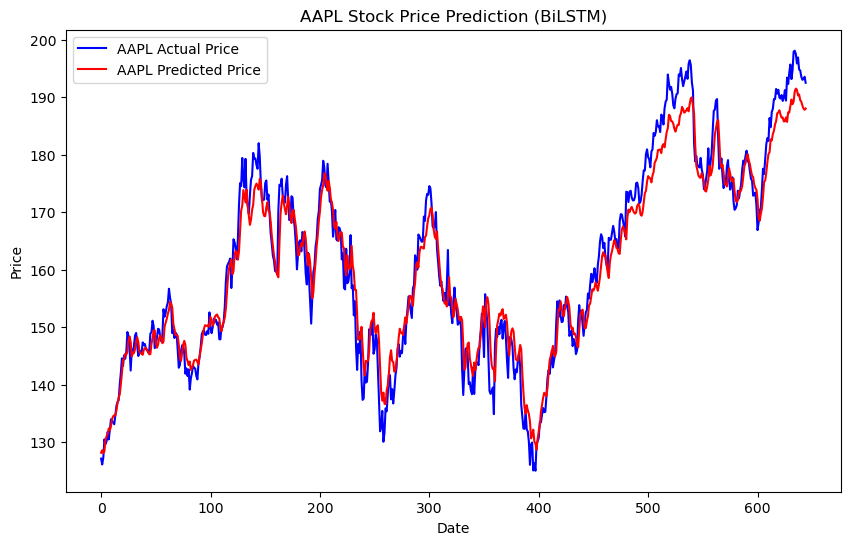

In [22]:
# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(actual_prices, color='blue', label=f'{stock_symbol} Actual Price')
plt.plot(predictions, color='red', label=f'{stock_symbol} Predicted Price')
plt.title(f'{stock_symbol} Stock Price Prediction (BiLSTM)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [25]:
# Performance Evaluation (RMSE)
rmse = math.sqrt(mean_squared_error(actual_prices, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 3.8038331605127023


In [27]:
# Assuming your model is already trained
model.save('bilstm_stock_model_100_Epochs.h5')  # Save the model in HDF5 format